In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectPercentile, mutual_info_regression
from xgboost import XGBRegressor
from sklearn.impute import KNNImputer
from sklearn.model_selection import RandomizedSearchCV
from scipy import stats
from statsmodels.tsa.stattools import acf
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score


# Import data

In [15]:
gdpnow = pd.read_csv('gdpnow_hf.csv', index_col='Dates', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
gdpnow.index = pd.to_datetime(gdpnow.index)

In [16]:
gdpnow.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 2537 entries, 2014-05-01 to 2024-01-19
Data columns (total 73 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   GSUSFCI Index_x                                     2537 non-null   float64
 1   CESIUSD Index_x                                     2537 non-null   float64
 2   value                                               2537 non-null   float64
 3   value_CCLACBW027SBOG                                2537 non-null   float64
 4   value_WTISPLC                                       2537 non-null   float64
 5   value_EXPINF1YR                                     2537 non-null   float64
 6   value_STLPPM                                        2537 non-null   float64
 7   value_M2REAL                                        2537 non-null   float64
 8   value_UNRATE                                        2537 non

## Let's define X and y

In [17]:
# Target S&P
# Target = 'SPX Index '
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'NDX Index ', 'SPX Index ','value_SP500']

# # Target USDJPY
# Target = 'USDJPY Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USDJPY Curncy']

# # Target 2y Interest Rates
# Target = 'USOSFR2 Curncy'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'USOSFR2 Curncy', 'USOSFR10 Curncy']

# # Target WTI Oil
# Target = 'CL1 Comdty'
# Drop = ['Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
#        'Days until advance estimate', 'Forecast Error', 'Data releases', 'CL1 Comdty']

# Target GDP
Target = 'Final_GDP_Interp'
Drop = ['GDP Nowcast', 'Final_GDP_Interp', 'Quarter being forecasted', 'Advance Estimate From BEA', 'Publication Date of Advance Estimate',
       'Days until advance estimate', 'Forecast Error', 'Data releases']

# How to deal with all the NAs ?

From here on lets try two different datasets as in how to work with the NAs:
1. ffil
2. dropping NAs

In [18]:
len(gdpnow.columns)

73

In [19]:
gdpnow_filled = gdpnow.fillna(method='ffill')
# Two variables are empty quite a lot
gdpnow_dropped = gdpnow.dropna(axis=0, thresh=len(gdpnow.columns)-2)

In [20]:
gdpnow_filled.shape, gdpnow_dropped.shape

((2537, 73), (1496, 73))

# Defining X and y

We now need the X and Y for the three different data sets

In [21]:
# defining X and y for all three data sets (initial, dropped and filled)
X = gdpnow.drop(columns=Drop)
y = gdpnow[Target]

X_filled = gdpnow_filled.drop(columns=Drop)
y_filled = gdpnow_filled[Target]

X_dropped = gdpnow_dropped.drop(columns=Drop)
y_dropped = gdpnow_dropped[Target]

assert(X.shape[0]==y.shape[0])
assert(X_filled.shape[0]==y_filled.shape[0])
assert(X_dropped.shape[0]==y_dropped.shape[0])

In [22]:
X_dropped

,GSUSFCI Index_x,CESIUSD Index_x,value,value_CCLACBW027SBOG,value_WTISPLC,value_EXPINF1YR,value_STLPPM,value_M2REAL,value_UNRATE,value_PPIACO,...,"Net Exports (previous, $Bil 2009)",PCE,PCE Goods,PCE Services,Previous change in private inventories ($Bil 2009),Residential,S&L,Services exports,Services imports,Structures
Dates,,,,,,,,,,,,,,,,,,,,,
2014-05-01,99.01,-28.7,4.29,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,...,-414.0,4.5,5.8,3.9,70.0,4.6,1.4,2.5,4.0,1.8
2014-05-02,99.00,-18.9,4.29,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,...,-414.0,4.6,5.8,3.9,58.0,4.6,1.3,2.5,4.0,1.8
2014-05-06,99.02,-12.0,4.29,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,...,-414.0,4.4,5.4,3.9,58.0,4.5,1.3,2.7,3.3,1.8
2014-05-09,99.04,-9.1,4.21,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,...,-414.0,4.4,5.4,3.9,72.0,4.5,1.3,2.7,3.3,1.8
2014-05-12,99.01,-6.6,4.21,608.7653,102.18,1.768390,0.227347,4778.4,6.3,208.000,...,-414.0,4.4,5.4,3.9,72.0,4.5,1.3,2.7,3.3,1.8
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-01-11,99.35,8.1,6.66,1033.2235,74.15,2.418633,0.940888,6710.6,3.7,251.328,...,-930.7,2.6,2.5,2.6,77.8,0.1,3.6,5.6,5.7,2.1
2024-01-12,99.34,7.5,6.66,1033.2235,74.15,2.418633,0.940888,6710.6,3.7,251.328,...,-930.7,2.6,2.5,2.6,77.8,0.1,3.6,5.6,5.7,2.0
2024-01-17,99.51,1.4,6.66,1035.5004,74.15,2.418633,0.940888,6710.6,3.7,251.328,...,-930.7,2.8,3.6,2.4,77.8,0.2,3.6,5.6,5.7,2.0


In [23]:
# Splitting into test and train sets
X_train, X_test, y_train, y_test = \
    train_test_split(X, y, test_size=0.20)

X_filled_train, X_filled_test, y_filled_train, y_filled_test = \
    train_test_split(X_filled, y_filled, test_size=0.20)

X_dropped_train, X_dropped_test, y_dropped_train, y_dropped_test = \
    train_test_split(X_dropped, y_dropped, test_size=0.20)


# Pipeline

In [24]:
preproc = Pipeline([
    ('imputer', KNNImputer(n_neighbors=5)),
    ('scaler', RobustScaler())
])

preproc_selector = Pipeline([
    ('preprocessing', preproc),  # Include the preprocessing steps with PCA
    ('feature_selection', SelectPercentile(
        mutual_info_regression,
        percentile=43 # Keep 90% of all features
    ))
])

# Modeling

In [25]:
#Modeling with initial dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='r2',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=2,
#     #random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search.fit(X_train, y_train)

# print("Best parameters found: ", random_search.best_params_)
# print("Best score found: ", random_search.best_score_)

In [26]:
# random_search.score(X_test, y_test)

In [27]:
# #Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': [0.1],
#     'model__max_depth': [16, 20],
# }

# pipe = Pipeline([
#     ('preprocessor', preproc),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [28]:
# random_search_filled.score(X_filled_test, y_filled_test)

In [29]:
#Modeling with 'dropped' dataset

model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': [200],
    'model__learning_rate': [0.1],
    'model__max_depth': [16, 20],
}

pipe = Pipeline([
    ('preprocessor', preproc),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=2,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_)

Fitting 5 folds for each of 2 candidates, totalling 10 fits


/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/sklearn/model_selection/_search.py:307: UserWarning: The total space of parameters 2 is smaller than n_iter=100. Running 2 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   6.0s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   6.2s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   6.2s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   6.2s
[CV] END model__learning_rate=0.1, model__max_depth=16, model__n_estimators=200; total time=   6.2s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   6.6s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   6.6s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   6.7s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   2.0s
[CV] END model__learning_rate=0.1, model__max_depth=20, model__n_estimators=200; total time=   2.0s


In [30]:
random_search_dropped.score(X_dropped_test, y_dropped_test)

-0.2963369221374774

In [31]:
y_dropped_pred = random_search_dropped.predict(X_dropped_test)

In [32]:
from sklearn.metrics import mean_absolute_error, r2_score

# Calculate evaluation metrics
mae_train = mean_absolute_error(y_dropped_train, random_search_dropped.predict(X_dropped_train))
mae_test = mean_absolute_error(y_dropped_test, random_search_dropped.predict(X_dropped_test))
r2_train = r2_score(y_dropped_train, random_search_dropped.predict(X_dropped_train))
r2_test = r2_score(y_dropped_test, random_search_dropped.predict(X_dropped_test))

print("Train MAE:", mae_train)
print("Test MAE:", mae_test)
print("Train R^2:", r2_train)
print("Test R^2:", r2_test)

Train MAE: 0.0004164300979402172
Test MAE: 0.2963369221374774
Train R^2: 0.9999999909482215
Test R^2: 0.9037397573200381


# Finetuning

### Using a feature selector

We have shown that either filling in or dropping gives way more promising results than just imputing

Thus, we will focus on these approaches

In [33]:
#Modeling with filled dataset

# model = XGBRegressor(random_state=42)

# param_distributions = {
#     'model__n_estimators': [200],
#     'model__learning_rate': stats.uniform(0.01 , 0.5),
#     'model__max_depth': [16, 20],
#      'preprocessor_selector__feature_selection__percentile': [60, 70, 80, 90],
# }

# pipe = Pipeline([
#     ('preprocessor_selector', preproc_selector),
#     ('model', model)
# ])

# random_search_filled = RandomizedSearchCV(
#     pipe,
#     param_distributions=param_distributions,
#     n_iter=100,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
#     scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
#     cv=5,
#     verbose=0,
#     random_state=42,
#     n_jobs=-1  # Use all available cores
# )

# random_search_filled.fit(X_filled_train, y_filled_train)

# print("Best parameters found: ", random_search_filled.best_params_)
# print("Best score found: ", random_search_filled.best_score_)

In [34]:
#Modeling with dropped dataset

""" model = XGBRegressor(random_state=42)

param_distributions = {
    'model__n_estimators': stats.randint(100,300),
    'model__learning_rate': stats.uniform(0.01 , 0.5),
    'model__max_depth': stats.randint(6,20),
    'preprocessor_selector__feature_selection__percentile': stats.uniform(10,90),
}

pipe = Pipeline([
    ('preprocessor_selector', preproc_selector),
    ('model', model)
])

random_search_dropped = RandomizedSearchCV(
    pipe,
    param_distributions=param_distributions,
    n_iter=1000,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.
    scoring='neg_mean_absolute_error',  # Assuming MSE is the metric of interest; adjust as needed.
    cv=5,
    verbose=0,
    random_state=42,
    n_jobs=-1  # Use all available cores
)

random_search_dropped.fit(X_dropped_train, y_dropped_train)

print("Best parameters found: ", random_search_dropped.best_params_)
print("Best score found: ", random_search_dropped.best_score_) """

' model = XGBRegressor(random_state=42)\n\nparam_distributions = {\n    \'model__n_estimators\': stats.randint(100,300),\n    \'model__learning_rate\': stats.uniform(0.01 , 0.5),\n    \'model__max_depth\': stats.randint(6,20),\n    \'preprocessor_selector__feature_selection__percentile\': stats.uniform(10,90),\n}\n\npipe = Pipeline([\n    (\'preprocessor_selector\', preproc_selector),\n    (\'model\', model)\n])\n\nrandom_search_dropped = RandomizedSearchCV(\n    pipe,\n    param_distributions=param_distributions,\n    n_iter=1000,  # Number of parameter settings that are sampled. n_iter trades off runtime vs quality of the solution.\n    scoring=\'neg_mean_absolute_error\',  # Assuming MSE is the metric of interest; adjust as needed.\n    cv=5,\n    verbose=0,\n    random_state=42,\n    n_jobs=-1  # Use all available cores\n)\n\nrandom_search_dropped.fit(X_dropped_train, y_dropped_train)\n\nprint("Best parameters found: ", random_search_dropped.best_params_)\nprint("Best score found: 

In [35]:
random_search_dropped.score(X_dropped_test, y_dropped_test)
# {'model__learning_rate': 0.2793508989763571, 'model__max_depth': 9, 'model__n_estimators': 105, 'preprocessor_selector__feature_selection__percentile': 43.47394011251784}

-0.2963369221374774

# Best Parameters

In [36]:
# {'model__learning_rate': 0.27629471627579294, 'model__max_depth': 12, 'model__n_estimators': 200, 'preprocessor_selector__feature_selection__percentile': 43.23074333589065}

# Fitting best model 

In [37]:
# Defining the best model

model_best =  XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)


# Creating the pipeline with memory caching
pipe_best = make_pipeline(preproc_selector, model_best)

# Assuming X_train and y_train are already defined and contain your training data
score = cross_val_score(pipe_best, X_dropped_train, y_dropped_train, cv=5, scoring='neg_mean_absolute_error')

# Printing the standard deviation and mean of the cross-validation scores
print(score.std())
print(score.mean())

0.06341497708871695
-0.1983137745386337


In [38]:
pipe_best.fit(X_dropped_train, y_dropped_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer', KNNImputer()),
                                                  ('scaler', RobustScaler())])),
                                 ('feature_selection',
                                  SelectPercentile(percentile=43,
                                                   score_func=<function mutual_info_regression at 0x17d40a4d0>))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.275,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

# Predictions

In [39]:
y_pred = pipe_best.predict(X_dropped_test)

In [40]:
y_pred = pd.Series(y_pred).reset_index(drop = True)

In [41]:
y_pred.index = y_dropped_test.index
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
df_plot = pd.concat([gdpnow.loc[X_dropped_test.index]['Days until advance estimate'], y_dropped_test, y_pred], axis=1)


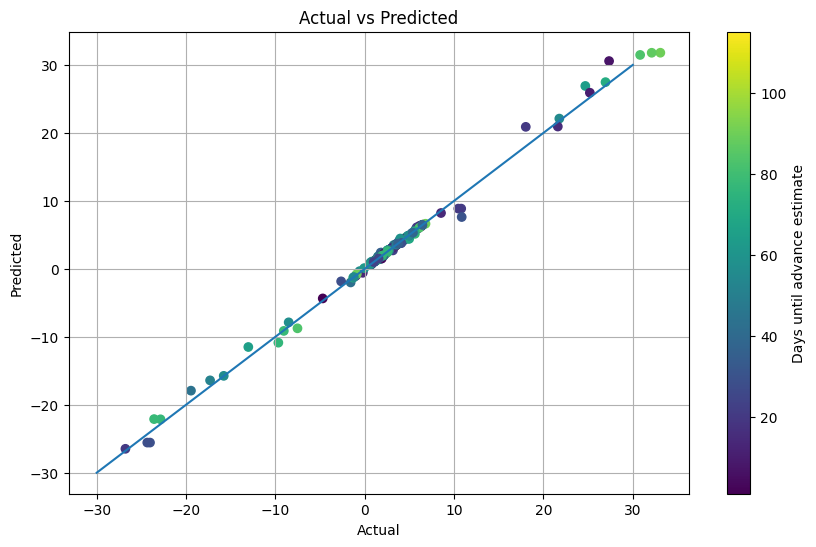

In [42]:
a=[-30,30]
b=[-30,30]

plt.figure(figsize=(10, 6))
plt.plot(a,b)
scatter = plt.scatter(df_plot['Final_GDP_Interp'], df_plot[0], c=df_plot['Days until advance estimate'], cmap='viridis')
plt.colorbar(scatter, label='Days until advance estimate')
plt.xlabel('Actual')
plt.ylabel('Predicted')
plt.title('Actual vs Predicted')
plt.grid(True)
plt.show()

# Comparing scores with GDPNOW

In [43]:
gdpnow_test = gdpnow_dropped['GDP Nowcast']
gdpnow_test = gdpnow_test.interpolate(method='time')
gdp_test = gdpnow_dropped['Final_GDP_Interp']

In [44]:
def forecast_accuracy(y_pred: pd.Series, y_true: pd.Series) -> float:

    mape = np.mean(np.abs(y_pred - y_true)/np.abs(y_true))  # Mean Absolute Percentage Error
    me = np.mean(y_pred - y_true)             # ME
    mae = np.mean(np.abs(y_pred - y_true))    # MAE
    mpe = np.mean((y_pred - y_true)/y_true)   # MPE
    rmse = np.mean((y_pred - y_true)**2)**.5  # RMSE
    corr = np.corrcoef(y_pred, y_true)[0,1]   # Correlation between the Actual and the Forecast
    if type(y_pred) == pd.Series:
        mins = np.amin(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.values.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    else:
        mins = np.amin(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
        maxs = np.amax(np.hstack([y_pred.reshape(-1,1), y_true.values.reshape(-1,1)]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(y_pred-y_true, fft=False)[1]                      # Lag 1 Autocorrelation of Error

    forecast = ({
        'mape':mape,
        'me':me,
        'mae': mae,
        'mpe': mpe,
        'rmse':rmse,
        'acf1':acf1,
        'corr':corr,
        'minmax':minmax
    })

    return forecast

In [45]:
forecast_accuracy(pipe_best.predict(X_dropped_test), y_dropped_test)

{'mape': 0.05279603226141725,
 'me': 0.01182579651555389,
 'mae': 0.1721908678862108,
 'mpe': -0.0029471400514306813,
 'rmse': 0.46335293334952543,
 'acf1': -0.0006796757179394618,
 'corr': 0.9974360076345201,
 'minmax': 0.01733142691783962}

In [46]:
forecast_accuracy(gdpnow_test,gdp_test)

/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/1438552970.py:15: RuntimeWarning: divide by zero encountered in divide
  minmax = 1 - np.mean(mins/maxs)             # minmax


{'mape': 1.0052173257056338,
 'me': 0.4431112847125225,
 'mae': 2.7196656763835896,
 'mpe': 0.22596797133268812,
 'rmse': 7.243805910567935,
 'acf1': 0.9706041856039092,
 'corr': 0.5693452275251626,
 'minmax': inf}

# Loss curves

[0]	validation_0-mae:1.87568	validation_1-mae:2.13133
[1]	validation_0-mae:1.38595	validation_1-mae:1.57409
[2]	validation_0-mae:1.03835	validation_1-mae:1.17142
[3]	validation_0-mae:0.78354	validation_1-mae:0.88108
[4]	validation_0-mae:0.59323	validation_1-mae:0.66394
[5]	validation_0-mae:0.45029	validation_1-mae:0.50897
[6]	validation_0-mae:0.35116	validation_1-mae:0.40887
[7]	validation_0-mae:0.27361	validation_1-mae:0.34187
[8]	validation_0-mae:0.21420	validation_1-mae:0.29170
[9]	validation_0-mae:0.17827	validation_1-mae:0.26680
[10]	validation_0-mae:0.15152	validation_1-mae:0.24943
[11]	validation_0-mae:0.11950	validation_1-mae:0.22807
[12]	validation_0-mae:0.09701	validation_1-mae:0.21451
[13]	validation_0-mae:0.08517	validation_1-mae:0.20808
[14]	validation_0-mae:0.07404	validation_1-mae:0.20217


/Users/thomasbowden/.pyenv/versions/lewagon/envs/project-btm/lib/python3.10/site-packages/xgboost/sklearn.py:889: UserWarning: `eval_metric` in `fit` method is deprecated for better compatibility with scikit-learn, use `eval_metric` in constructor or`set_params` instead.
  warnings.warn(


[15]	validation_0-mae:0.06201	validation_1-mae:0.19434
[16]	validation_0-mae:0.05573	validation_1-mae:0.19179
[17]	validation_0-mae:0.05053	validation_1-mae:0.18954
[18]	validation_0-mae:0.04452	validation_1-mae:0.18610
[19]	validation_0-mae:0.04086	validation_1-mae:0.18400
[20]	validation_0-mae:0.03864	validation_1-mae:0.18325
[21]	validation_0-mae:0.03645	validation_1-mae:0.18239
[22]	validation_0-mae:0.03325	validation_1-mae:0.18133
[23]	validation_0-mae:0.03040	validation_1-mae:0.17931
[24]	validation_0-mae:0.02865	validation_1-mae:0.17910
[25]	validation_0-mae:0.02629	validation_1-mae:0.17795
[26]	validation_0-mae:0.02538	validation_1-mae:0.17766
[27]	validation_0-mae:0.02446	validation_1-mae:0.17726
[28]	validation_0-mae:0.02348	validation_1-mae:0.17710
[29]	validation_0-mae:0.02185	validation_1-mae:0.17624
[30]	validation_0-mae:0.02052	validation_1-mae:0.17602
[31]	validation_0-mae:0.01975	validation_1-mae:0.17559
[32]	validation_0-mae:0.01919	validation_1-mae:0.17537
[33]	valid

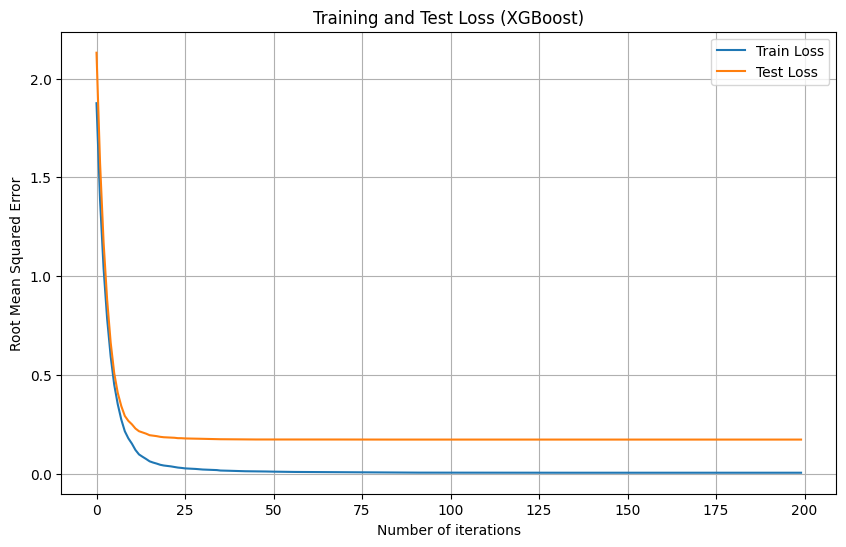

In [47]:
import xgboost as xgb
import matplotlib.pyplot as plt

# Assuming you have your X_train, y_train, X_test, and y_test data prepared

# Define the XGBoost regressor
xgb_regressor = xgb.XGBRegressor(n_estimators=200, max_depth = 9, learning_rate = 0.275, random_state=42, reg_lambda = 0.01)

X_train_preproc = preproc_selector.fit_transform(X_dropped_train, y_dropped_train)
X_test_preproc = preproc_selector.transform(X_dropped_test)

# Fit the model with evaluation set
eval_set = [(X_train_preproc, y_dropped_train), (X_test_preproc, y_dropped_test)]
xgb_regressor.fit(X_train_preproc, y_dropped_train, eval_set=eval_set, eval_metric="mae", verbose=True)

# Extract training and validation loss from the model's history
results = xgb_regressor.evals_result()
train_loss = results['validation_0']['mae']
test_loss = results['validation_1']['mae']

# Plot the train and test loss
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Train Loss')
plt.plot(test_loss, label='Test Loss')
plt.xlabel('Number of iterations')
plt.ylabel('Root Mean Squared Error')
plt.title('Training and Test Loss (XGBoost)')
plt.legend()
plt.grid()
plt.show()

# Using test_data.csv 

In [48]:
test_data = pd.read_csv('data/test_data.csv', index_col='Release Date', parse_dates=True) #date_parser=dateparse)
# Ensure that load_df index is in the same date format
test_data.index = pd.to_datetime(test_data.index)
test_data = test_data.dropna()


/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/4022950943.py:1: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  test_data = pd.read_csv('data/test_data.csv', index_col='Release Date', parse_dates=True) #date_parser=dateparse)


### Check if release data is same as interpolated data in gdpnow

In [49]:
cutoff_date_1 = gdpnow.index[0]
cutoff_date_2 = gdpnow.index[-1]

rows_to_remove_1 = test_data.index[test_data.index < cutoff_date_1]
rows_to_remove_2 = test_data.index[test_data.index > cutoff_date_2]
# Drop the rows using the index positions
test_data = test_data.drop(rows_to_remove_1)
test_data = test_data.drop(rows_to_remove_2)

from pandas.testing import assert_series_equal
assert_series_equal(test_data["BEA's Advance Estimate"], gdpnow.loc[test_data.index]['Final_GDP_Interp'], check_names=False)

### New train and test


In [50]:
X_test = pd.DataFrame()

for date in test_data.index:
    if date in X_dropped.index:
        X_test = X_test.append(X_dropped.loc[date])
    else:
        prev_date = date - pd.DateOffset(days=1)
        while prev_date not in X_dropped.index and prev_date >= min(X_dropped.index):
            prev_date -= pd.DateOffset(days=1)
        if prev_date in X_dropped.index:
            X_test = X_test.append(X_dropped.loc[prev_date])


/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/3865305197.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/3865305197.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/3865305197.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  X_test = X_test.append(X_dropped.loc[prev_date])
/var/folders/v5/5q966zvj59j8p5z9qllhcr7r0000gp/T/ipykernel_47311/3865305197.py:11: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas

In [51]:
y_test = test_data['BEA\'s Advance Estimate']
y_test.index = X_test.index
gdnow_testdata = test_data['Model Forecast Right Before BEA\'s Advance Estimate']
gdnow_testdata.index = X_test.index
X_train = X_dropped.drop(X_test.index)
y_train = y_dropped.drop(X_test.index)

# Refitting best model on new Train and Test

pipe_best.fit(X_train, X_test)

In [52]:
pipe_best.fit(X_train, y_train)

Pipeline(steps=[('pipeline',
                 Pipeline(steps=[('preprocessing',
                                  Pipeline(steps=[('imputer', KNNImputer()),
                                                  ('scaler', RobustScaler())])),
                                 ('feature_selection',
                                  SelectPercentile(percentile=43,
                                                   score_func=<function mutual_info_regression at 0x17d40a4d0>))])),
                ('xgbregressor',
                 XGBRegressor(base_score=None, booster=None, callbacks=None,
                              colsample_bylevel=None, colsample...
                              feature_types=None, gamma=None, grow_policy=None,
                              importance_type=None,
                              interaction_constraints=None, learning_rate=0.275,
                              max_bin=None, max_cat_threshold=None,
                              max_cat_to_onehot=None, max_delta_step=None,
                              max_depth=9, max_leaves=None,
                              min_child_weight=None, missing=nan,
                              monotone_constraints=None, multi_strategy=None,
                              n_estimators=200, n_jobs=None,
                              num_parallel_tree=None, random_state=42, ...))])

In [53]:
forecast_accuracy(pipe_best.predict(X_test), y_test)

{'mape': 0.06744833387481959,
 'me': 0.014270306794267005,
 'mae': 0.20614039235993423,
 'mpe': 0.019489308844152686,
 'rmse': 0.445520915343031,
 'acf1': -0.48649611724971814,
 'corr': 0.9988112079968947,
 'minmax': 0.044911466781916376}

In [54]:
predictions = pipe_best.predict(X_test)
btm_error = predictions - y_test
gdpnow_error = gdnow_testdata-y_test


df = pd.DataFrame({
    'BTM Predictions': predictions,
    'BEA\'s Advance Estimate': y_test,
    'GDP Now' : gdnow_testdata,
    'BTM Error' : btm_error,
    'GDP Now Error' : gdpnow_error


})

df


,BTM Predictions,BEA's Advance Estimate,GDP Now,BTM Error,GDP Now Error
2023-10-25,4.749721,4.88,5.41,-0.130279,0.53
2023-07-26,2.194728,2.41,2.41,-0.215272,0.00
2023-04-26,1.102573,1.06,1.13,0.042573,0.07
2023-01-20,2.865954,2.89,3.53,-0.024046,0.64
2022-10-26,2.199190,2.57,3.09,-0.370810,0.52
2022-07-27,-0.979313,-0.93,-1.20,-0.049313,-0.27
2022-04-27,-1.447842,-1.41,0.37,-0.037842,1.78
2022-01-26,6.621419,6.89,6.50,-0.268581,-0.39
2021-10-27,2.137348,2.02,0.19,0.117348,-1.83
2021-07-28,6.472726,6.50,6.43,-0.027274,-0.07


## Shapley Feature Test

PermutationExplainer explainer: 39it [00:20,  1.34s/it]                        


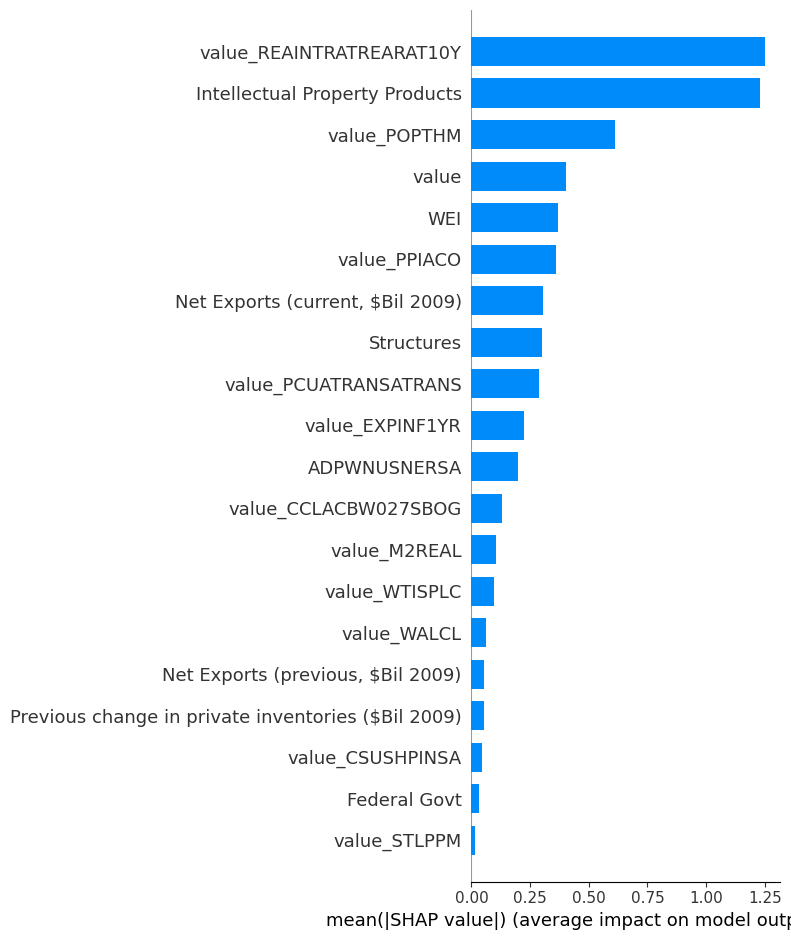

In [57]:
# Feature Selection
import shap

# Compute SHAP values
# # Initialize the explainer on the entire pipeline
explainer = shap.Explainer(pipe_best.predict, X_test)

# Compute SHAP values
shap_values = explainer(X_test)

# # Visualize the feature importance
# shap.plots.bar(shap_values)
# Plot SHAP values to understand feature importance
shap.summary_plot(shap_values, X_test, plot_type="bar")